In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
winequality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = winequality.data.features
y = winequality.data.targets

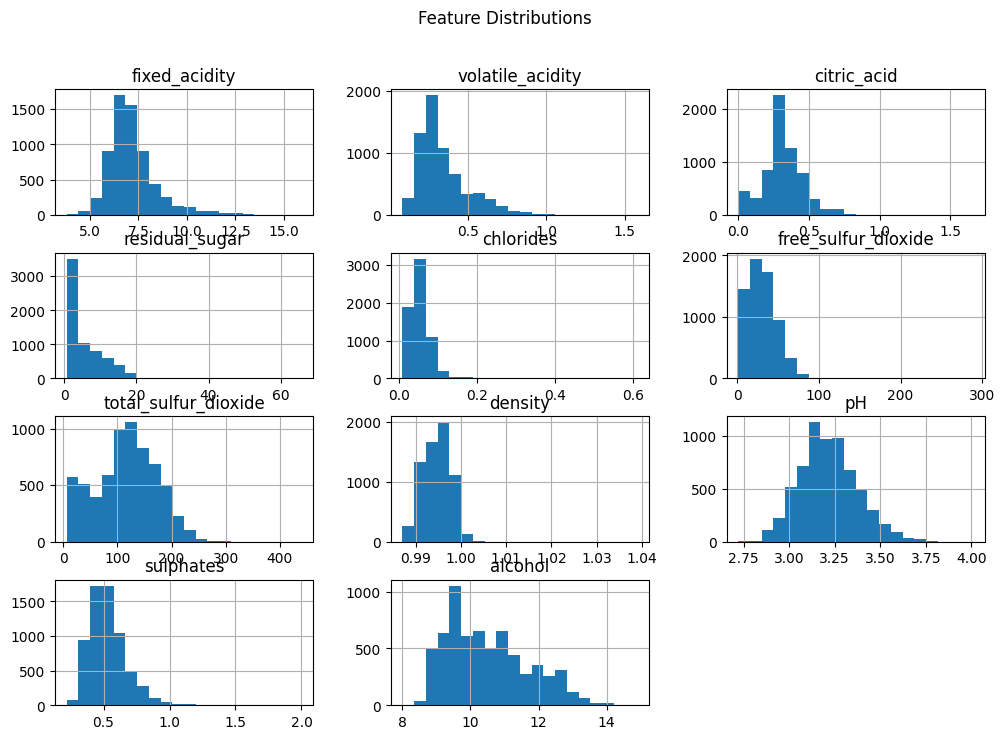

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

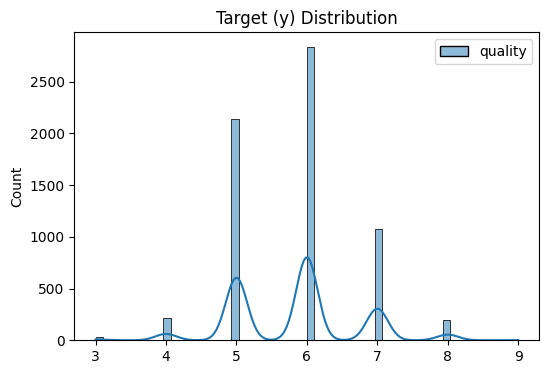

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

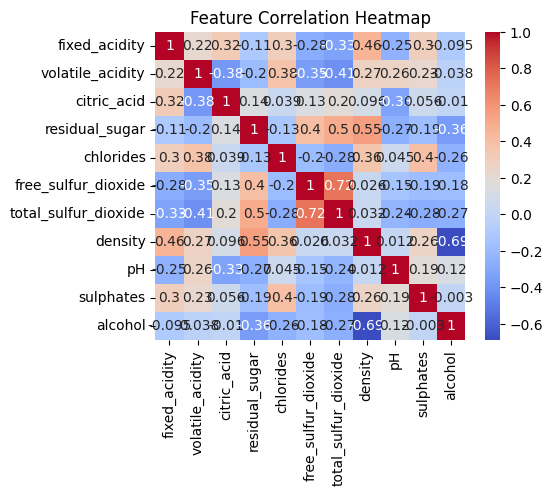

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=8, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=8)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.081652                 1.152568             1.254462   
1                  1.145529                 1.057623             1.140539   
2                  1.155254                 1.090907             1.331579   
3                  1.180724                 1.181051             1.151985   
4                  1.044609                 1.103489             1.095864   
5                  1.034716                 1.090417             1.245606   
6                  1.091988                 1.192027             1.306532   
7                  1.125679                 1.134570             1.216875   
mean               1.107519                 1.125331             1.217930   
std                0.052889                 0.047578             0.082899   

      DefaultBART_Rhat_RMSE  
0                  1.201621  
1                  1.414332  
2                  1.743677

In [10]:
rhat_df.to_csv("results/real2_WineQuality_rhat.csv", index=False)

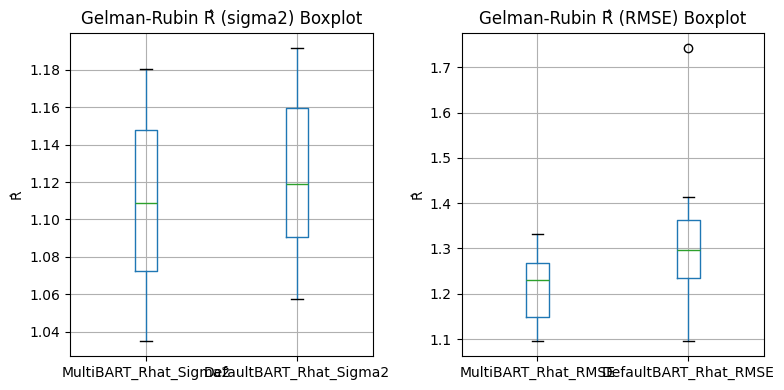

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

INFO:2025-11-24 15:47:12,397:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-11-24 15:47:13,135:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-11-24 15:47:13,920:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to op

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.474663  0.478704  0.476685  0.389235  0.423869
1      0.465512  0.465591  0.463041  0.359287  0.416377
2      0.489336  0.499642  0.494605  0.384622  0.407832
3      0.457365  0.467142  0.462256  0.346424  0.386311
4      0.445103  0.455158  0.455026  0.363344  0.391157
5      0.457619  0.469209  0.468411  0.369662  0.415728
6      0.475204  0.481351  0.481846  0.377460  0.403745
7      0.471557  0.478310  0.477519  0.379783  0.425224
mean   0.467045  0.474388  0.472424  0.371227  0.408780
std    0.013671  0.013346  0.012734  0.014333  0.014371



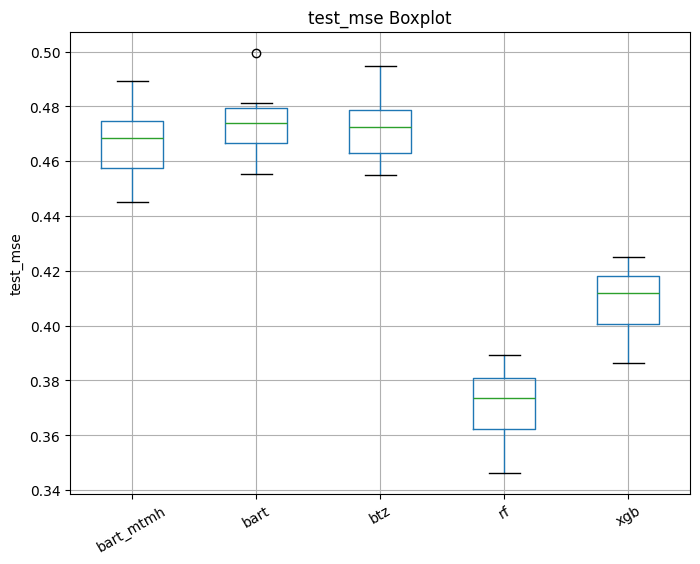

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.373748  0.387051  0.405461  0.051776  0.063149
1      0.381533  0.397962  0.415851  0.053084  0.067435
2      0.373403  0.386953  0.400854  0.051887  0.057334
3      0.380426  0.393441  0.419258  0.054751  0.057431
4      0.377546  0.392507  0.411875  0.051670  0.068970
5      0.378502  0.400510  0.409501  0.051974  0.068156
6      0.372942  0.383421  0.405331  0.051510  0.060060
7      0.378478  0.387753  0.405558  0.051897  0.070524
mean   0.377072  0.391200  0.409211  0.052319  0.064132
std    0.003316  0.005938  0.006147  0.001093  0.005345



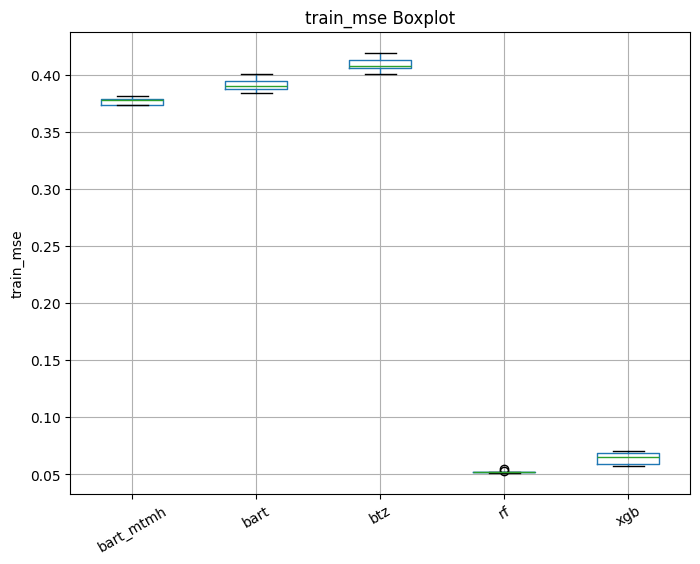

pi_length:
      bart_mtmh      bart       btz
0      2.538710  2.568465  2.659349
1      2.580010  2.571065  2.667371
2      2.562346  2.566267  2.646621
3      2.577289  2.588560  2.683438
4      2.580218  2.588598  2.656108
5      2.571248  2.602155  2.651402
6      2.563314  2.568120  2.662893
7      2.573220  2.577558  2.655042
mean   2.568294  2.578848  2.660278
std    0.013778  0.012962  0.011367



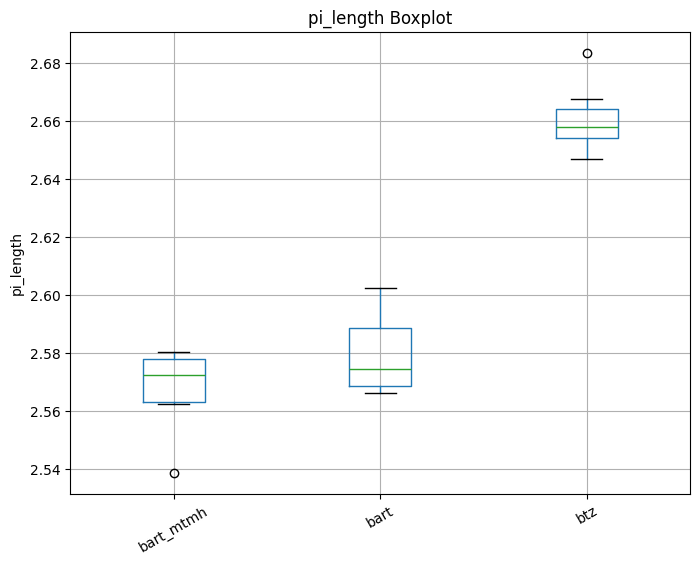

coverage:
      bart_mtmh      bart       btz
0      0.933538  0.939077  0.939692
1      0.942154  0.939077  0.948923
2      0.933538  0.927385  0.939692
3      0.936615  0.930462  0.947692
4      0.943385  0.940308  0.943385
5      0.940308  0.942769  0.944000
6      0.938462  0.940308  0.939692
7      0.937846  0.937846  0.939692
mean   0.938231  0.937154  0.942846
std    0.003647  0.005339  0.003814



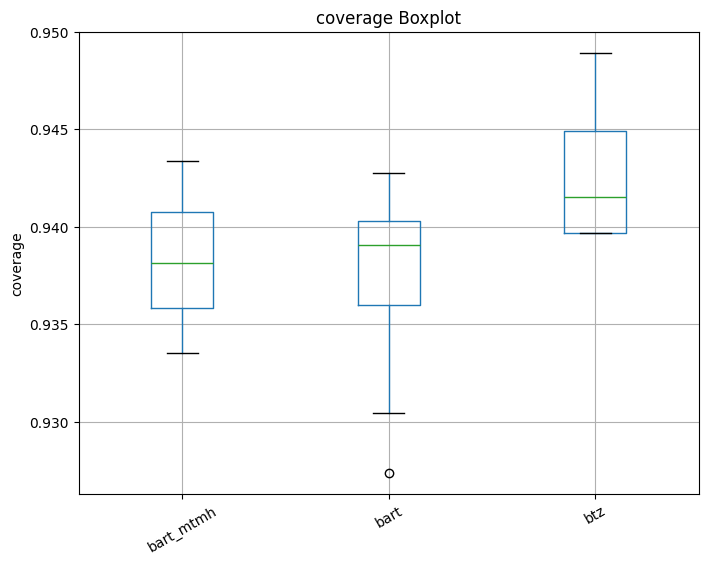

train_time:
       bart_mtmh       bart        btz        rf       xgb
0     312.917335  43.443577  91.800154  3.722332  0.222189
1     308.817553  43.118637  88.061726  5.647786  0.364338
2     308.412345  42.785871  85.993711  5.923941  0.411664
3     313.634261  44.175473  91.145688  3.817983  0.278718
4     316.161333  47.207689  89.680193  3.379976  0.213825
5     312.474422  44.037393  91.713679  3.889650  0.217256
6     313.842021  44.234273  91.814685  3.593025  0.208186
7     309.544218  43.169862  88.742198  5.314019  0.390260
mean  311.975436  44.021597  89.869004  4.411089  0.288305
std     2.763859   1.395004   2.142670  1.032605  0.086908



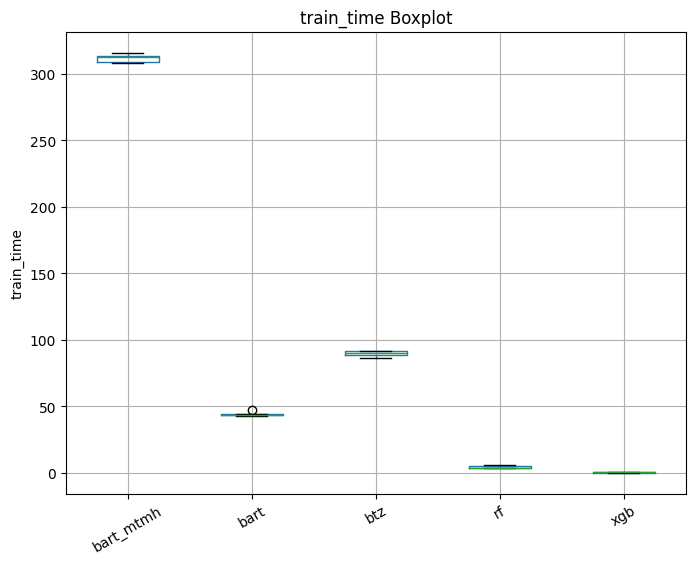

In [12]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=8, n_skip=1000, n_post=1000, n_trees=100, n_jobs=8)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [13]:
for k, v in mse_results.items():
    csv_name = f"results/real2_WineQuality_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [14]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real2_WineQuality_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 20, 50],
    n_runs=8, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=-1
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real2_WineQuality_tries.csv", index=False)

In [15]:
import pandas as pd
df = pd.read_csv("results/real2_WineQuality_tries.csv")
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage   Train_Time
0            1     1.079789   1.339718  0.469830  0.937000    79.372779
1            5     1.153363   1.209838  0.471534  0.939000   184.588895
2           10     1.107519   1.217930  0.464081  0.939154   311.085539
3           20     1.134442   1.157712  0.465162  0.937385   553.186342
4           50     1.103644   1.186571  0.465814  0.939308  1248.411795
